# DATA 300: Statistical Machine Learning

# Homework 4

## Name: Selene Nguyen

In [1]:
# Python Version 3.9.13, conda version 23.1.0

In [2]:
# Import packages
import sklearn # v 1.0.2
import numpy as np # v 1.21.5
import pandas as pd # v 1.4.4
import pmdarima as pm # v 2.0.3
import ydata_profiling as pp # v 4.5.1
import matplotlib.pyplot as plt # v 3.5.2
import statsmodels.api as sm # v 0.13.2
import sweetviz as sv # v 2.2.1
import statsmodels.tsa.stattools as stattools # v 0.13.2
import warnings as ww

from sklearn.linear_model import LogisticRegression # v 1.0.2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # v 1.0.2
from sklearn.model_selection import train_test_split # v 1.0.2
from sklearn.metrics import mean_absolute_error # v 1.0.2
from sklearn.metrics import mean_squared_error # v 1.0.2
from sklearn.metrics import mean_absolute_percentage_error # v 1.0.2
from sklearn.metrics import confusion_matrix # v 1.0.2
from sklearn.metrics import roc_curve, auc, roc_auc_score # v 1.0.2
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve # v 1.0.2
from sklearn.utils import resample # v 1.0.2

from sklearn.impute import SimpleImputer # v 1.0.2 # Impute missing values

from imblearn.over_sampling import RandomOverSampler, SMOTE # v 0.11.0
from imblearn.under_sampling import RandomUnderSampler # v 0.11.0

import matplotlib
matplotlib.use('Qt5Agg')  # for GUI display
import matplotlib.pyplot as plt # v 3.5.2
import seaborn as sns # v. 0.11.2

ww.filterwarnings("ignore")
%matplotlib inline

In [3]:
# Read in the dataset
loan_df = pd.read_csv("/Users/nmn/Downloads/loan_default_data_set.csv")

In [4]:
loan_df.head()

tot_balance  avg_bal_cards  credit_age  credit_age_good_account  \
0  102956.1101    14819.05740         238                      104   
1  132758.7258    18951.93455         384                      197   
2  124658.9174    15347.92969         277                      110   
3  133968.5369    14050.71334         375                      224   
4  143601.8017    14858.51527         374                      155   

   credit_card_age  num_acc_30d_past_due_12_months  \
0              264                               0   
1              371                               0   
2              288                               0   
3              343                               0   
4              278                               0   

   num_acc_30d_past_due_6_months  num_mortgage_currently_past_due  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   tot_amount_currently_past_due  num_inq_12_month  ...  num_card_12_month  \
0                            0.0                 0  ...                  1   
1                            0.0                 0  ...                  0   
2                            0.0                 0  ...                  0   
3                            0.0                 2  ...                  1   
4                            0.0                 0  ...                  0   

   num_auto_ 36_month  uti_open_card  pct_over_50_uti  uti_max_credit_line  \
0                   0       0.366737         0.342183             0.513934   
1                   0       0.490809         0.540671             0.418016   
2                   0       0.359074         0.338560             0.341627   
3                   0       0.700379         0.683589             0.542940   
4                   0       0.647351         0.510812             0.632934   

   pct_card_over_50_uti  ind_XYZ    rep_income  rep_education Def_ind  
0              0.550866        0  118266.32130        college       0  
1                   NaN        0   89365.05765        college       0  
2              0.451417        0  201365.12130        college       0  
3              0.607843        0  191794.48550        college       0  
4              0.573680        0  161465.36790       graduate       0  

[5 rows x 21 columns]

### Data Preprocessing

**Impute Missing Data**

Based on Homework 3's EDA, 'rep_education' (categorical), 'pct_card_over_50_uti', and 'rep_income' (numerical) columns have missing values.

In [5]:
# 'rep_education' column
categorical_imputer = SimpleImputer(strategy='most_frequent')
loan_df['rep_education'] = categorical_imputer.fit_transform(loan_df['rep_education'].values.reshape(-1, 1))

In [6]:
# numerical columns
numeric_imputer = SimpleImputer(strategy='mean')
loan_df['pct_card_over_50_uti'] = numeric_imputer.fit_transform(loan_df[['pct_card_over_50_uti']])
loan_df['rep_income'] = numeric_imputer.fit_transform(loan_df[['rep_income']])

In [7]:
loan_df.isna().sum()

tot_balance                        0
avg_bal_cards                      0
credit_age                         0
credit_age_good_account            0
credit_card_age                    0
num_acc_30d_past_due_12_months     0
num_acc_30d_past_due_6_months      0
num_mortgage_currently_past_due    0
tot_amount_currently_past_due      0
num_inq_12_month                   0
num_card_inq_24_month              0
num_card_12_month                  0
num_auto_ 36_month                 0
uti_open_card                      0
pct_over_50_uti                    0
uti_max_credit_line                0
pct_card_over_50_uti               0
ind_XYZ                            0
rep_income                         0
rep_education                      0
Def_ind                            0
dtype: int64

**1. Create three samples of the data:**

**a. The first should be created by oversampling the minority class so that the number of observations of the minority and majority class are the same (18,000 for each class) and you have 36, 000 observations in total.**

In [47]:
# Number of observations in each class
loan_df['Def_ind'].value_counts()

0    18000
1     2000
Name: Def_ind, dtype: int64

Class 0 is the majority class; Class 1 is the minority class

In [8]:
# Separate the dataset into two datasets
dataset_1 = loan_df[loan_df['Def_ind'] == 0]  # Class 0
dataset_2 = loan_df[loan_df['Def_ind'] == 1]  # Class 1

In [9]:
# Check the number of observations in dataset_1
len(dataset_1)

18000

In [10]:
# Check the number of observations in dataset_2
len(dataset_2)

2000

In [11]:
# Oversample (bootstrap) the minority class
oversampled_dataset_2 = resample(dataset_2, replace=True, n_samples=18000, random_state=42) # Replace must be True because oversampling

In [12]:
# Concatenate the new oversampled minority dataset to the majority dataset
oversampled_data = pd.concat([dataset_1, oversampled_dataset_2])

In [13]:
# Save dataset
oversampled_data.to_csv('/Users/nmn/Downloads/oversampled_data.csv', index=True)

In [14]:
oversampled_data

tot_balance  avg_bal_cards  credit_age  credit_age_good_account  \
0      102956.11010   14819.057400         238                      104   
1      132758.72580   18951.934550         384                      197   
2      124658.91740   15347.929690         277                      110   
3      133968.53690   14050.713340         375                      224   
4      143601.80170   14858.515270         374                      155   
...             ...            ...         ...                      ...   
14269   77308.29691    9562.452360         289                      160   
16445  102096.23460   12521.854100         329                      175   
7218    75163.61145    2683.930371         282                      161   
6388   105165.70390   11544.689600         154                       67   
13940   96799.08000    6955.179825         210                      115   

       credit_card_age  num_acc_30d_past_due_12_months  \
0                  264                               0   
1                  371                               0   
2                  288                               0   
3                  343                               0   
4                  278                               0   
...                ...                             ...   
14269              256                               1   
16445              319                               0   
7218               271                               0   
6388               188                               0   
13940              247                               0   

       num_acc_30d_past_due_6_months  num_mortgage_currently_past_due  \
0                                  0                                0   
1                                  0                                0   
2                                  0                                0   
3                                  0                                0   
4                                  0                                0   
...                              ...                              ...   
14269                              1                                0   
16445                              0                                0   
7218                               0                                0   
6388                               0                                0   
13940                              0                                0   

       tot_amount_currently_past_due  num_inq_12_month  ...  \
0                                0.0                 0  ...   
1                                0.0                 0  ...   
2                                0.0                 0  ...   
3                                0.0                 2  ...   
4                                0.0                 0  ...   
...                              ...               ...  ...   
14269                            0.0                 3  ...   
16445                            0.0                 0  ...   
7218                             0.0                 0  ...   
6388                             0.0                 4  ...   
13940                            0.0                 0  ...   

       num_card_12_month  num_auto_ 36_month  uti_open_card  pct_over_50_uti  \
0                      1                   0       0.366737         0.342183   
1                      0                   0       0.490809         0.540671   
2                      0                   0       0.359074         0.338560   
3                      1                   0       0.700379         0.683589   
4                      0                   0       0.647351         0.510812   
...                  ...                 ...            ...              ...   
14269                  1                   1       0.648877         0.673450   
16445                  1                   0       0.518088         0.459295   
7218                   0                   0       0.539

In [15]:
# Check the number of observations for Class 1 of the new oversampled dataset
len(oversampled_data[oversampled_data['Def_ind']==1])

18000

**b. The second should be created by undersampling the majority class (2000 observations for each class) and you have 4000 observations in total.**

In [16]:
# Undersample the majority class
undersampled_dataset_1 = resample(dataset_1, replace=False, n_samples=2000, random_state=42)

In [17]:
# Concatenate the new undersampled majority dataset to the minority dataset
undersampled_data = pd.concat([undersampled_dataset_1, dataset_2])

In [18]:
# Save dataset
undersampled_data.to_csv('/Users/nmn/Downloads/undersampled_data.csv', index=True)

In [19]:
undersampled_data

tot_balance  avg_bal_cards  credit_age  credit_age_good_account  \
2856   111977.12460   12823.313160         144                       88   
8325    66321.69123    7132.268872         309                      128   
10239   97961.09217    7684.659369         221                      123   
6072   142252.03140   17130.868230         300                      148   
797     92976.55077   11501.033440         349                      174   
...             ...            ...         ...                      ...   
19961  101185.23900    8551.413462         344                      190   
19979  101238.81730   12260.749900         148                       52   
19984  109717.64730   12295.671170         129                       60   
19994   99102.92799   11033.901590         222                      119   
19998   96742.36371   11743.262370         275                      141   

       credit_card_age  num_acc_30d_past_due_12_months  \
2856               191                               0   
8325               358                               0   
10239              209                               0   
6072               322                               1   
797                386                               0   
...                ...                             ...   
19961              361                               1   
19979              218                               0   
19984              226                               0   
19994              259                               0   
19998              294                               2   

       num_acc_30d_past_due_6_months  num_mortgage_currently_past_due  \
2856                               0                                0   
8325                               0                                0   
10239                              0                                0   
6072                               0                                0   
797                                0                                0   
...                              ...                              ...   
19961                              0                                0   
19979                              0                                0   
19984                              0                                0   
19994                              0                                0   
19998                              1                                1   

       tot_amount_currently_past_due  num_inq_12_month  ...  \
2856                        0.000000                 0  ...   
8325                        0.000000                 1  ...   
10239                       0.000000                 0  ...   
6072                      170.116655                 0  ...   
797                         0.000000                 0  ...   
...                              ...               ...  ...   
19961                       0.000000                 0  ...   
19979                       0.000000                 1  ...   
19984                       0.000000                 3  ...   
19994                       0.000000                 0  ...   
19998                    3009.387661                 0  ...   

       num_card_12_month  num_auto_ 36_month  uti_open_card  pct_over_50_uti  \
2856                   0                   0       0.543409         0.415367   
8325                   0                   0       0.487481         0.461952   
10239                  0                   0       0.434590         0.492010   
6072                   0                   0       0.447209         0.400874   
797                    0                   0       0.496548         0.317660   
...                  ...                 ...            ...              ...   
19961                  0                   0       0.517914         0.508975   
19979                  1                   0       0.902818         0.794570   
19984                  0                   0       0.688

In [20]:
# Check the number of observations for Class 0 of the new oversampled dataset
len(undersampled_data[undersampled_data['Def_ind']==0])

2000

**c. Use SMOTE to create the third data set. This is also an oversampling technique.**

In [21]:
# Encode "rep_education"
loan_df_dummies = pd.get_dummies(loan_df, columns=['rep_education'], prefix='rep')

# Columns names
print(loan_df_dummies.columns)

Index(['tot_balance', 'avg_bal_cards', 'credit_age', 'credit_age_good_account',
       'credit_card_age', 'num_acc_30d_past_due_12_months',
       'num_acc_30d_past_due_6_months', 'num_mortgage_currently_past_due',
       'tot_amount_currently_past_due', 'num_inq_12_month',
       'num_card_inq_24_month', 'num_card_12_month', 'num_auto_ 36_month',
       'uti_open_card', 'pct_over_50_uti', 'uti_max_credit_line',
       'pct_card_over_50_uti', 'ind_XYZ', 'rep_income', 'Def_ind',
       'rep_college', 'rep_graduate', 'rep_high_school', 'rep_other'],
      dtype='object')


In [22]:
# Separate dataset into Y and X variables
y = loan_df_dummies["Def_ind"] # "Def_ind" column
X = loan_df_dummies.loc[:, loan_df_dummies.columns != "Def_ind"] # All columns except the "Def_ind" column

In [23]:
# Initialize SMOTE
smote = SMOTE(sampling_strategy=1, random_state=42)

# Apply SMOTE to create an oversampled dataset
X_smote, y_smote = smote.fit_resample(X, y)

# Concatenate the oversampled dataset with the original dataset
smote_data = pd.concat([X_smote, y_smote], axis=1)

# Save the oversampled dataset
smote_data.to_csv('smote_oversampled_data.csv', index=True)

In [24]:
smote_data

tot_balance  avg_bal_cards  credit_age  credit_age_good_account  \
0      102956.110100   14819.057400         238                      104   
1      132758.725800   18951.934550         384                      197   
2      124658.917400   15347.929690         277                      110   
3      133968.536900   14050.713340         375                      224   
4      143601.801700   14858.515270         374                      155   
...              ...            ...         ...                      ...   
35995   88250.717381    9208.283288         314                      150   
35996  145541.415393   17686.523997         347                      174   
35997   68028.613864    4451.785186         353                      164   
35998   81689.868788   10062.472282         226                      103   
35999  133575.805332   13721.124267         231                       94   

       credit_card_age  num_acc_30d_past_due_12_months  \
0                  264                               0   
1                  371                               0   
2                  288                               0   
3                  343                               0   
4                  278                               0   
...                ...                             ...   
35995              318                               2   
35996              339                               0   
35997              295                               0   
35998              230                               0   
35999              294                               0   

       num_acc_30d_past_due_6_months  num_mortgage_currently_past_due  \
0                                  0                                0   
1                                  0                                0   
2                                  0                                0   
3                                  0                                0   
4                                  0                                0   
...                              ...                              ...   
35995                              1                                1   
35996                              0                                0   
35997                              0                                0   
35998                              0                                0   
35999                              0                                0   

       tot_amount_currently_past_due  num_inq_12_month  ...  pct_over_50_uti  \
0                           0.000000                 0  ...         0.342183   
1                           0.000000                 0  ...         0.540671   
2                           0.000000                 0  ...         0.338560   
3                           0.000000                 2  ...         0.683589   
4                           0.000000                 0  ...         0.510812   
...                              ...               ...  ...              ...   
35995                    9592.746341                 0  ...         0.443421   
35996                       0.000000                 2  ...         0.496538   
35997                       0.000000                 0  ...         0.413578   
35998                       0.000000                 0  ...         0.371931   
35999                       0.000000                 2  ...         0.484353   

       uti_max_credit_line  pct_card_over_50_uti  ind_XYZ     rep_income  \
0                 0.513934              0.550866        0  118266.321300   
1                 0.418016              0.550964        0   89365.057650   
2                 0.341627              0.451417        0  201365.121300   
3                 0.542940              0.607843        0  191794.485500   
4                 0.632934              0.573680        0  161465.367900   
...                    ...                   ...      ...            ...   
35995             0.457871   

In [25]:
# Check the number of observations for Class 1 of the new oversampled dataset
len(smote_data[smote_data['Def_ind']==1])

18000

**2. Fit a Logistic regression and Linear Discriminant Analysis (LDA) on all three datasets so that you have 6 model objects. A model for each of the three datasets you have created by using different sampling techniques.**

**& 3. Compare model performance on accuracy, recall, and precision. Report your findings.**

### Oversampled Dataset

In [26]:
# Encode "rep_education"
oversampled_dummies = pd.get_dummies(oversampled_data, columns=['rep_education'])

# Columns names
print(oversampled_dummies.columns)

Index(['tot_balance', 'avg_bal_cards', 'credit_age', 'credit_age_good_account',
       'credit_card_age', 'num_acc_30d_past_due_12_months',
       'num_acc_30d_past_due_6_months', 'num_mortgage_currently_past_due',
       'tot_amount_currently_past_due', 'num_inq_12_month',
       'num_card_inq_24_month', 'num_card_12_month', 'num_auto_ 36_month',
       'uti_open_card', 'pct_over_50_uti', 'uti_max_credit_line',
       'pct_card_over_50_uti', 'ind_XYZ', 'rep_income', 'Def_ind',
       'rep_education_college', 'rep_education_graduate',
       'rep_education_high_school', 'rep_education_other'],
      dtype='object')


In [27]:
# Separate dataset into Y and X variables
y_over = oversampled_dummies["Def_ind"] # "Def_ind" column
X_over = oversampled_dummies.loc[:, oversampled_dummies.columns != "Def_ind"] # All columns except the "Def_ind" column

In [28]:
# Split the data set into training set and testing set (80% - 20%) using train_test_split
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=5)

***Logistic Regression***

In [29]:
# Instantiate the model
over_log_model = LogisticRegression()

# Fit the model
over_log_model.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred_over = over_log_model.predict(X_test_over)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test_over, y_pred_over)
precision = precision_score(y_test_over, y_pred_over)
recall = recall_score(y_test_over, y_pred_over)

# Generate classification report
target_names = ['not defaulted', 'defaulted']
classification_rep = classification_report(y_test_over, y_pred_over, target_names=target_names)

# Interpret the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Classification Report:\n", classification_rep)

Accuracy: 0.63875
Precision: 0.6904059040590406
Recall: 0.5150013762730525
Classification Report:
                precision    recall  f1-score   support

not defaulted       0.61      0.76      0.68      3567
    defaulted       0.69      0.52      0.59      3633

     accuracy                           0.64      7200
    macro avg       0.65      0.64      0.63      7200
 weighted avg       0.65      0.64      0.63      7200



***LDA***

In [30]:
# Create and fit the LDA model
over_lda = LinearDiscriminantAnalysis()
over_lda.fit(X_train_over, y_train_over)

LinearDiscriminantAnalysis()

In [31]:
# Make predictions on the test set
y_pred_over = over_lda.predict(X_test_over)

# Calculate accuracy
accuracy = accuracy_score(y_test_over, y_pred_over)

# Calculate precision with average='weighted'
precision_weighted = precision_score(y_test_over, y_pred_over, average='weighted')

# Calculate recall with average='weighted'
recall_weighted = recall_score(y_test_over, y_pred_over, average='weighted')

# Report the results
print(f'Accuracy: {accuracy}')
print(f'Precision (Weighted): {precision_weighted}')
print(f'Recall (Weighted): {recall_weighted}')

Accuracy: 0.7194444444444444
Precision (Weighted): 0.7206128935289794
Recall (Weighted): 0.7194444444444444


In [32]:
print(classification_report(y_test_over, y_pred_over, digits=3))

              precision    recall  f1-score   support

           0      0.703     0.751     0.726      3567
           1      0.738     0.689     0.712      3633

    accuracy                          0.719      7200
   macro avg      0.720     0.720     0.719      7200
weighted avg      0.721     0.719     0.719      7200



### Undersampled Dataset

In [33]:
# Encode "rep_education"
undersampled_dummies = pd.get_dummies(undersampled_data, columns=['rep_education'])

# Columns names
print(undersampled_dummies.columns)

Index(['tot_balance', 'avg_bal_cards', 'credit_age', 'credit_age_good_account',
       'credit_card_age', 'num_acc_30d_past_due_12_months',
       'num_acc_30d_past_due_6_months', 'num_mortgage_currently_past_due',
       'tot_amount_currently_past_due', 'num_inq_12_month',
       'num_card_inq_24_month', 'num_card_12_month', 'num_auto_ 36_month',
       'uti_open_card', 'pct_over_50_uti', 'uti_max_credit_line',
       'pct_card_over_50_uti', 'ind_XYZ', 'rep_income', 'Def_ind',
       'rep_education_college', 'rep_education_graduate',
       'rep_education_high_school', 'rep_education_other'],
      dtype='object')


In [34]:
# Separate dataset into Y and X variables
y_under = undersampled_dummies["Def_ind"] # "Def_ind" column
X_under = undersampled_dummies.loc[:, undersampled_dummies.columns != "Def_ind"] # All columns except the "Def_ind" column

In [35]:
# Split the data set into training set and testing set (80% - 20%) using train_test_split
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2, random_state=5)

***Logistic Regression***

In [36]:
# Instantiate the model
under_log_model = LogisticRegression()

# Fit the model
under_log_model.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred_under = under_log_model.predict(X_test_under)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test_under, y_pred_under)
precision = precision_score(y_test_under, y_pred_under)
recall = recall_score(y_test_under, y_pred_under)

# Generate classification report
target_names = ['not defaulted', 'defaulted']
classification_rep = classification_report(y_test_under, y_pred_under, target_names=target_names)

# Interpret the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Classification Report:\n", classification_rep)

Accuracy: 0.645
Precision: 0.711340206185567
Recall: 0.5085995085995086
Classification Report:
                precision    recall  f1-score   support

not defaulted       0.61      0.79      0.69       393
    defaulted       0.71      0.51      0.59       407

     accuracy                           0.65       800
    macro avg       0.66      0.65      0.64       800
 weighted avg       0.66      0.65      0.64       800



***LDA***

In [37]:
# Create and fit the LDA model
under_lda = LinearDiscriminantAnalysis()
under_lda.fit(X_train_under, y_train_under)

LinearDiscriminantAnalysis()

In [38]:
# Make predictions on the test set
y_pred_under = under_lda.predict(X_test_under)

# Calculate accuracy
accuracy = accuracy_score(y_test_under, y_pred_under)

# Calculate precision with average='weighted'
precision_weighted = precision_score(y_test_under, y_pred_under, average='weighted')

# Calculate recall with average='weighted'
recall_weighted = recall_score(y_test_under, y_pred_under, average='weighted')

# Report the results
print(f'Accuracy: {accuracy}')
print(f'Precision (Weighted): {precision_weighted}')
print(f'Recall (Weighted): {recall_weighted}')

Accuracy: 0.74125
Precision (Weighted): 0.7417592662064826
Recall (Weighted): 0.74125


In [39]:
print(classification_report(y_test_under, y_pred_under, digits=3))

              precision    recall  f1-score   support

           0      0.728     0.756     0.742       393
           1      0.755     0.727     0.741       407

    accuracy                          0.741       800
   macro avg      0.742     0.741     0.741       800
weighted avg      0.742     0.741     0.741       800



### SMOTE Dataset

In [40]:
# Separate dataset into Y and X variables
y_smote = smote_data["Def_ind"] # "Def_ind" column
X_smote = smote_data.loc[:, smote_data.columns != "Def_ind"] # All columns except the "Def_ind" column

In [41]:
# Split the data set into training set and testing set (80% - 20%) using train_test_split
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=5)

***Logistic Regression***

In [42]:
# Instantiate the model
smote_log_model = LogisticRegression()

# Fit the model
smote_log_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_smote = smote_log_model.predict(X_test_smote)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test_smote, y_pred_smote)
precision = precision_score(y_test_smote, y_pred_smote)
recall = recall_score(y_test_smote, y_pred_smote)

# Generate classification report
target_names = ['not defaulted', 'defaulted']
classification_rep = classification_report(y_test_smote, y_pred_smote, target_names=target_names)

# Interpret the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Classification Report:\n", classification_rep)

Accuracy: 0.6205555555555555
Precision: 0.6639256346085091
Recall: 0.5089065497396547
Classification Report:
                precision    recall  f1-score   support

not defaulted       0.59      0.74      0.66      3551
    defaulted       0.66      0.51      0.58      3649

     accuracy                           0.62      7200
    macro avg       0.63      0.62      0.62      7200
 weighted avg       0.63      0.62      0.62      7200



***LDA***

In [43]:
# Create and fit the LDA model
smote_lda = LinearDiscriminantAnalysis()
smote_lda.fit(X_train_smote, y_train_smote)

LinearDiscriminantAnalysis()

In [44]:
# Make predictions on the test set
y_pred_smote = smote_lda.predict(X_test_smote)

# Calculate accuracy
accuracy = accuracy_score(y_test_smote, y_pred_smote)

# Calculate precision with average='weighted'
precision_weighted = precision_score(y_test_smote, y_pred_smote, average='weighted')

# Calculate recall with average='weighted'
recall_weighted = recall_score(y_test_smote, y_pred_smote, average='weighted')

# Report the results
print(f'Accuracy: {accuracy}')
print(f'Precision (Weighted): {precision_weighted}')
print(f'Recall (Weighted): {recall_weighted}')

Accuracy: 0.82125
Precision (Weighted): 0.8320945168848468
Recall (Weighted): 0.82125


In [45]:
print(classification_report(y_test_smote, y_pred_smote, digits=3))

              precision    recall  f1-score   support

           0      0.770     0.909     0.834      3551
           1      0.892     0.736     0.807      3649

    accuracy                          0.821      7200
   macro avg      0.831     0.822     0.820      7200
weighted avg      0.832     0.821     0.820      7200



Comparing the 6 models, it can be observed that the SMOTE LDA model has the highest accuracy, precision, and recall. However, the SMOTE logistic regression model has the lowest accuracy, precision, and recall. 

In general, LDA models performs better than logistic regression models, based on accuracy, precision, and recall.

**4. Plot an AUC_ROC curve and choose the best model based on the curve.**

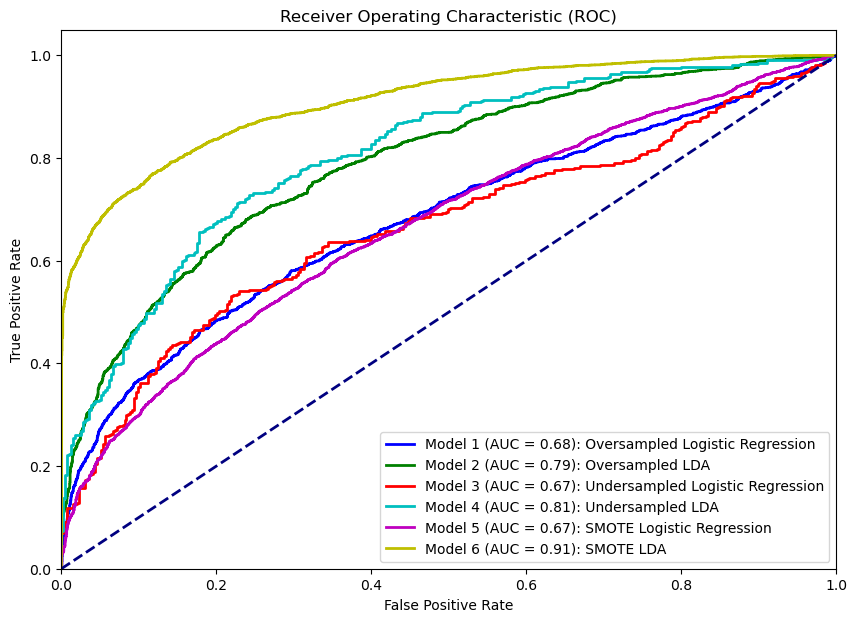

In [46]:
# Calculate ROC curve and AUC for each model

y_pred_proba1 = over_log_model.predict_proba(X_test_over)[::,1]
fpr1, tpr1, _ = roc_curve(y_test_over, y_pred_proba1)
roc_auc1 = auc(fpr1, tpr1)

y_pred_proba2 = over_lda.predict_proba(X_test_over)[::,1]
fpr2, tpr2, _ = roc_curve(y_test_over, y_pred_proba2)
roc_auc2 = auc(fpr2, tpr2)

y_pred_proba3 = under_log_model.predict_proba(X_test_under)[::,1]
fpr3, tpr3, _ = roc_curve(y_test_under, y_pred_proba3)
roc_auc3 = auc(fpr3, tpr3)

y_pred_proba4 = under_lda.predict_proba(X_test_under)[::,1]
fpr4, tpr4, _ = roc_curve(y_test_under, y_pred_proba4)
roc_auc4 = auc(fpr4, tpr4)

y_pred_proba5 = smote_log_model.predict_proba(X_test_smote)[::,1]
fpr5, tpr5, _ = roc_curve(y_test_smote, y_pred_proba5)
roc_auc5 = auc(fpr5, tpr5)

y_pred_proba6 = smote_lda.predict_proba(X_test_smote)[::,1]
fpr6, tpr6, _ = roc_curve(y_test_smote, y_pred_proba6)
roc_auc6 = auc(fpr6, tpr6)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr1, tpr1, color='b', lw=2, label='Model 1 (AUC = %0.2f): Oversampled Logistic Regression' % roc_auc1)
plt.plot(fpr2, tpr2, color='g', lw=2, label='Model 2 (AUC = %0.2f): Oversampled LDA' % roc_auc2)
plt.plot(fpr3, tpr3, color='r', lw=2, label='Model 3 (AUC = %0.2f): Undersampled Logistic Regression' % roc_auc3)
plt.plot(fpr4, tpr4, color='c', lw=2, label='Model 4 (AUC = %0.2f): Undersampled LDA' % roc_auc4)
plt.plot(fpr5, tpr5, color='m', lw=2, label='Model 5 (AUC = %0.2f): SMOTE Logistic Regression' % roc_auc5)
plt.plot(fpr6, tpr6, color='y', lw=2, label='Model 6 (AUC = %0.2f): SMOTE LDA' % roc_auc6)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**5. Which model would you prefer?  Explain.**

Based on the AUC_ROC curve, I would prefer SMOTE LDA model (Model 6), since the higher the AUC, the better the model is. Or in other words, the closer to the top left area the curve is, the better the model.
It is also observed that generally, LDA models are better then Logistic Regression models based on the curves.
For LDA, the SMOTE model performs the best, while for Logistic Regression, the first Oversampled model performs the best.

This is consistent with the results from comparing models based on accuracy, precision, and recall.